In [5]:
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
from sklearn import ensemble
%matplotlib inline
from collections import Counter
import sklearn.cross_validation
import math
import time

In [6]:
filename = "data_sci_snippet.csv.zip"
zf = zipfile.ZipFile(filename, 'r')
print zf.namelist()

['data_sci_snippet.csv']


In [7]:
def time_preprocessing(df, column_name):
    
    times = []
    count = 0
    start = time.time()
    for i in df[column_name]:
        count += 1
        if count % 100000 == 0:
            time_elapsed = time.time() - start
            #print "Count = %r, Time Elapsed = %r" %(count, time_elapsed)
        times.append(time.strptime(i, "%Y-%m-%d"))

    year = []
    month = []
    day = []
    day_of_week = []
    day_in_year = []

    for i in times:
        year.append(i[0])
        month.append(i[1])
        day.append(i[2])
        day_of_week.append(i[6])
        day_in_year.append(i[7])

    df['year'] = year
    df['month'] = month
    df['day'] = day
    df['day_of_week'] = day_of_week
    df['day_in_year'] = day_in_year
    df.drop([column_name], axis=1)
    return df

In [60]:
data = pd.read_csv(zf.open('data_sci_snippet.csv'))

one_hot_columns = ['Pool','ListingStatus','DwellingType']
count = 0
for i in one_hot_columns:
    dummies = pd.get_dummies(data[i])
    for j in dummies:
        data[j] = dummies[j]
        count += 1

data = time_preprocessing(data, 'ListDate')

# Remove Outliers
data = data[(data['ClosePrice'] != 1)]
data = data[(data['ListPrice'] <= 7000000)]

# Set Aside Data
data = data[:(len(data)-len(data)/20)]
print len(data)-(len(data)/20)
test_aside = data[(len(data)-(len(data)/20)):]

print data.shape
data[:5]

51658
(54376, 38)


,ListingId,LivingArea,NumBedrooms,NumBaths,Pool,ExteriorStories,ListDate,ListPrice,GeoLat,GeoLon,...,Mfg/Mobile Housing,Modular/Pre-Fab,Patio Home,Single Family - Detached,Townhouse,year,month,day,day_of_week,day_in_year
0,5077399,3054,4,2.5,Private,1,2014-03-04,675000,33.593239,-111.961056,...,0,0,0,1,0,2014,3,4,1,63
1,5077408,2230,4,2.0,Private,1,2014-03-01,475000,33.650984,-111.963151,...,0,0,0,1,0,2014,3,1,5,60
2,5077486,1601,3,2.0,Private,1,2014-03-01,279900,33.692122,-112.038019,...,0,0,0,1,0,2014,3,1,5,60
3,5077487,2440,4,2.5,None,2,2014-03-01,229900,33.647270,-112.251490,...,0,0,0,1,0,2014,3,1,5,60
4,5077489,3980,5,3.0,None,1,2014-03-01,385250,33.389139,-111.712757,...,0,0,0,1,0,2014,3,1,5,60


In [61]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

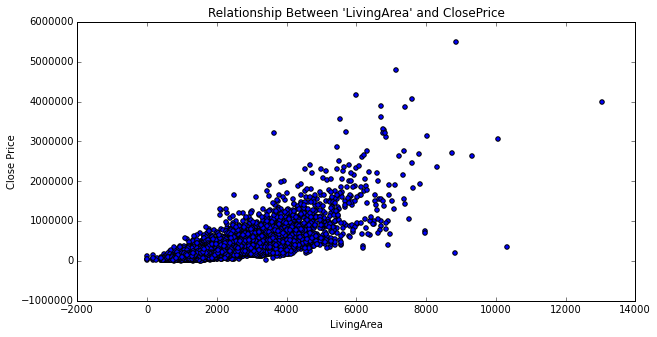

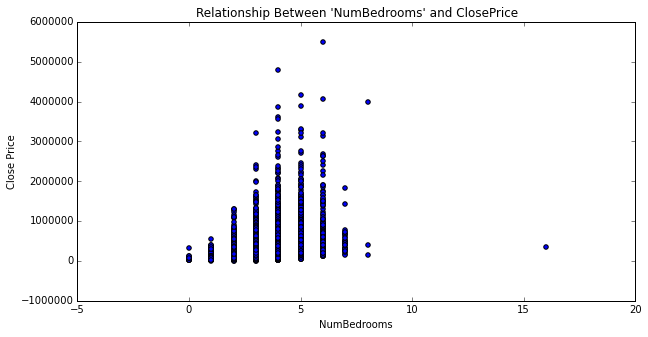

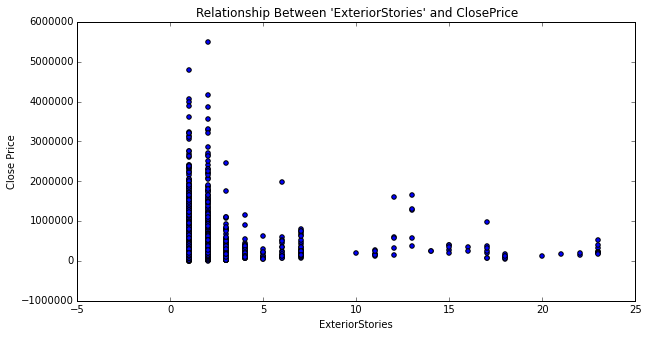

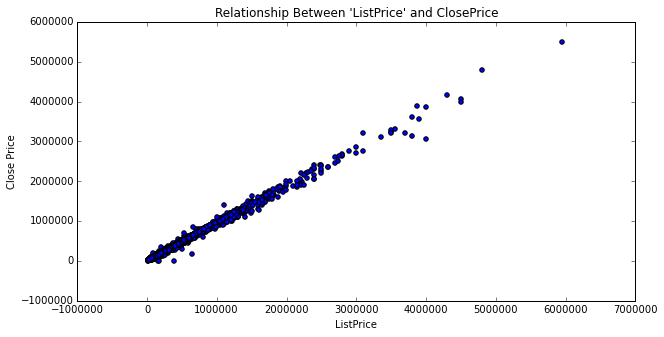

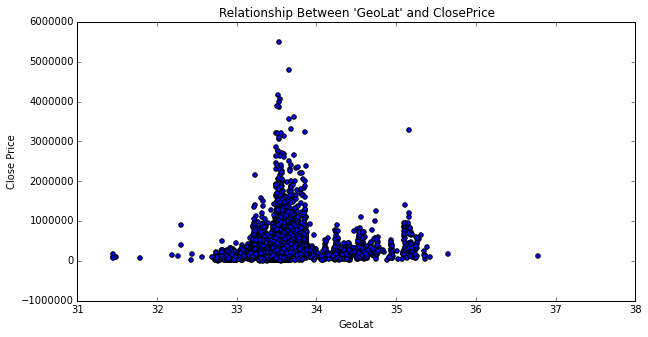

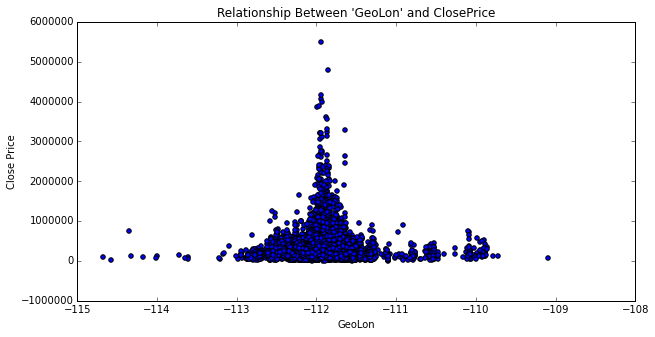

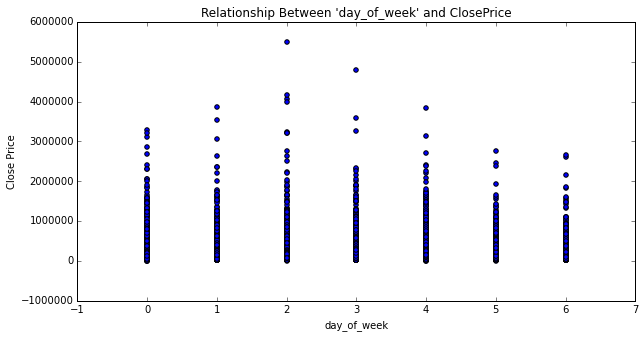

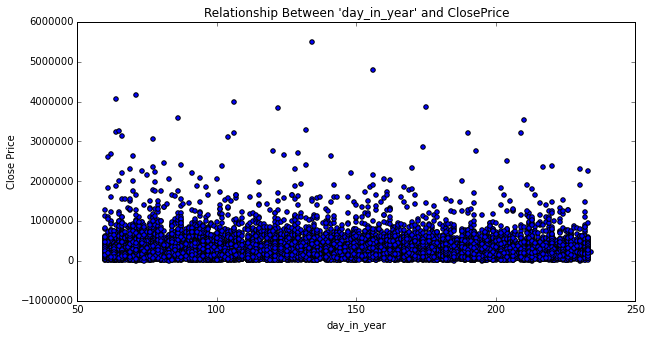

In [62]:
wanted = ['LivingArea', 'NumBedrooms','ExteriorStories','ListPrice','GeoLat','GeoLon','Month','Day','day_in_year','day_of_week']
for i in data:
    if i in wanted:
        plt.figure(figsize=(10,5))
        plt.scatter(data[i], data['ClosePrice'])
        plt.title('Relationship Between %r and ClosePrice'%i)
        plt.xlabel(i)
        plt.ylabel('Close Price')
        plt.show()

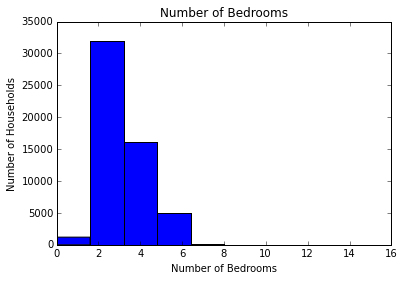

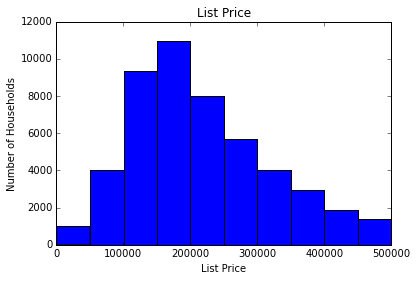

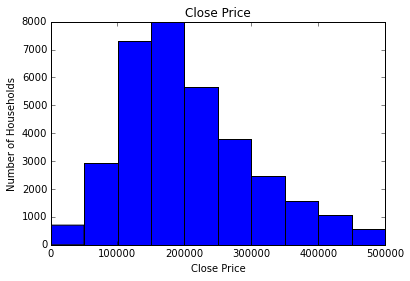

In [63]:
# Visualize Important Variables

plt.hist(data['NumBedrooms'])
plt.title('Number of Bedrooms')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Number of Households')
plt.show()


for_price_visualization = data[(data['ListPrice'] < 500000)]
plt.hist(np.array(for_price_visualization['ListPrice']))
plt.title('List Price')
plt.xlabel('List Price')
plt.ylabel('Number of Households')
plt.show()

for_close_price_visualization = data[(data['ClosePrice'] < 500000)]
plt.hist(np.array(for_close_price_visualization['ClosePrice'].dropna()))
plt.title('Close Price')
plt.xlabel('Close Price')
plt.ylabel('Number of Households')
plt.show()

In [64]:
# Look at linear relationship strength
data.corr()

,ListingId,LivingArea,NumBedrooms,NumBaths,ExteriorStories,ListPrice,GeoLat,GeoLon,ClosePrice,Both Private & Community,...,Mfg/Mobile Housing,Modular/Pre-Fab,Patio Home,Single Family - Detached,Townhouse,year,month,day,day_of_week,day_in_year
ListingId,1.000000,-0.018548,0.010366,-0.009079,-0.003014,-0.023523,0.001266,-0.005415,-0.027856,-0.013624,...,-0.001795,0.008093,-0.013056,0.010019,0.006984,NaN,0.981991,0.079702,-0.009154,0.997579
LivingArea,-0.018548,1.000000,0.685235,0.119595,0.077597,0.730729,0.038851,0.021560,0.730680,0.142867,...,-0.120140,-0.002991,-0.062920,0.338498,-0.179998,NaN,-0.018330,-0.001724,0.014244,-0.018649
NumBedrooms,0.010366,0.685235,1.000000,0.092122,0.015105,0.342028,-0.082090,-0.001154,0.360532,0.049046,...,-0.119481,-0.002447,-0.113005,0.478913,-0.242312,NaN,0.010569,0.002053,0.030843,0.010967
NumBaths,-0.009079,0.119595,0.092122,1.000000,0.018583,0.094403,0.008549,0.002051,0.066589,0.015989,...,-0.016102,0.000629,-0.007851,0.040053,-0.015823,NaN,-0.007892,-0.005405,0.007883,-0.008857
ExteriorStories,-0.003014,0.077597,0.015105,0.018583,1.000000,0.033981,0.002704,0.014531,0.023796,0.026262,...,-0.066071,-0.008526,-0.034617,-0.216614,0.113596,NaN,-0.003588,0.001625,0.003597,-0.003345
ListPrice,-0.023523,0.730729,0.342028,0.094403,0.033981,1.000000,0.138373,0.070845,0.997521,0.155794,...,-0.092763,-0.011166,-0.017275,0.162126,-0.088306,NaN,-0.023651,-0.006509,0.008503,-0.024823
GeoLat,0.001266,0.038851,-0.082090,0.008549,0.002704,0.138373,1.000000,-0.272625,0.132204,0.012978,...,0.045493,0.004016,0.004917,-0.047010,0.009775,NaN,-0.002314,-0.001040,-0.010408,-0.002533
GeoLon,-0.005415,0.021560,-0.001154,0.002051,0.014531,0.070845,-0.272625,1.000000,0.098683,-0.004116,...,0.072549,0.009141,0.012037,-0.039528,0.022209,NaN,-0.009474,0.008043,0.012609,-0.008091
ClosePrice,-0.027856,0.730680,0.360532,0.066589,0.023796,0.997521,0.132204,0.098683,1.000000,0.173922,...,-0.107744,-0.016144,-0.017645,0.198344,-0.111232,NaN,-0.027202,-0.007007,0.024938,-0.028484
Both Private & Community,-0.013624,0.142867,0.049046,0.015989,0.026262,0.155794,0.012978,-0.004116,0.173922,1.000000,...,-0.030502,-0.004865,-0.007913,0.015428,-0.015437,NaN,-0.013860,0.005145,0.006225,-0.012967


In [39]:
without_na = data.dropna()
# Split Training and Testing Data
x = without_na[['LivingArea', 'NumBedrooms', 'NumBaths', 'ExteriorStories', 'ListPrice',\
                'GeoLat', 'GeoLon','Both Private & Community','Private','Apartment Style/Flat',\
                'Gemini/Twin Home','Single Family - Detached','Townhouse']]
y = without_na['ClosePrice']


x_train, x_test, y_train, y_test = sklearn.cross_validation.train_test_split(
    x, y, test_size=0.05, random_state=42)

print x_train.shape
print x_test.shape
print y_train.shape
print y_test.shape

(35630, 13)
(1876, 13)
(35630,)
(1876,)


In [18]:
forest = ensemble.RandomForestRegressor(n_estimators = 1000)
forest.fit(x_train, y_train)
forest_predictions = forest.predict(x_test)

In [19]:
booster = ensemble.GradientBoostingRegressor(n_estimators = 200)
booster.fit(x_train, y_train)
booster_predictions = booster.predict(x_test)

In [20]:
predictions = (forest_predictions + booster_predictions)/2

In [21]:
# Root Mean Squared Error
def RMSE(predictions, actual):
    squared_error = (predictions - actual)**2
    MSE = squared_error.mean()
    RMSE = math.sqrt(MSE)
    return RMSE

In [22]:
# Mean Absolute Error
def MAE(predictions, actual):
    MAE = (abs(predictions-y_test).mean())
    return MAE

In [26]:
MAE(predictions, y_test)

6137.4969013701939

In [27]:
RMSE(predictions, y_test)

12007.3198803158

In [34]:
# Median Error
error_array = abs(predictions-y_test)
error_array.sort()
error_array[len(error_array)/2]

3702.9739825716242

In [23]:
1-((abs(predictions-y_test).mean())/y_test.mean())

0.97379498625246208

In [24]:
R2 = pd.Series(predictions).corr(pd.Series(y_test))**2
R2

0.9949565676120592

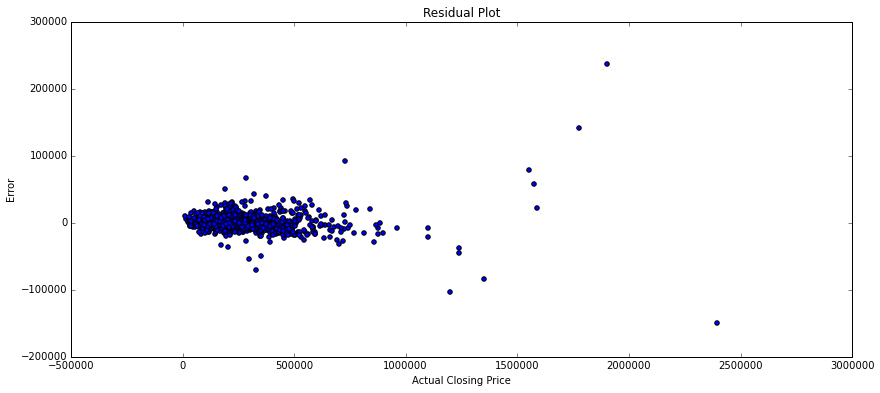

In [37]:
# Errors
plt.figure(figsize = (14, 6))
plt.scatter(y_test, predictions-y_test)
plt.title('Residual Plot')
plt.xlabel('Actual Closing Price')
plt.ylabel('Error')

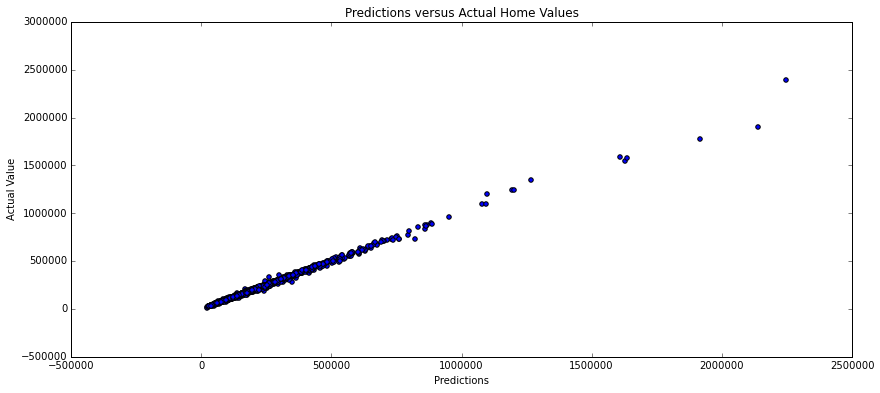

In [25]:
# Visualize Predictions

plt.figure(figsize = (14, 6))
plt.scatter(predictions, y_test)
plt.title('Predictions versus Actual Home Values')
plt.xlabel('Predictions')
plt.ylabel('Actual Value')